# Final Project DL model Notebook - sinple CNN model with two convolutional layers - v01

#### imports, settings and constants

In [1]:
import sys

from keras.models import Sequential
from keras.layers import BatchNormalization, Flatten, Dense, Conv2D, MaxPooling2D
from keras.optimizers import Adam
import numpy as np

from pathlib import Path

sys.path.append(str(Path.cwd().parent))
from utils import *

current_dir = Path.cwd()
HOME_DIR = current_dir.parent
DATA_DIR = HOME_DIR.joinpath('data')

# comment out one of the two path options to toggle between sample directory and all data
# path = DATA_DIR
path = DATA_DIR.joinpath('sample')
train_path = path.joinpath('train')
val_path = path.joinpath('valid')
test_path = path.joinpath('test')
results_path = path.joinpath('tesults')

# training variables
batch_size = 16
epochs = 4
learning_rate = 1e-4

Using Theano backend.


#### getting training and validation data in batches

In [2]:
batches = get_in_batches(train_path, batch_size=batch_size)
val_batches = get_in_batches(val_path, batch_size=batch_size)
test_batches = get_in_batches(test_path, batch_size=batch_size)

Found 1000 images belonging to 10 classes.
Found 200 images belonging to 10 classes.
Found 0 images belonging to 0 classes.


#### and getting the classes, labels and filenames for each batch

In [3]:
trn_classes = batches.classes
val_classes = val_batches.classes
trn_labels = onehot(batches.classes)
val_labels = onehot(val_batches.classes)
trn_filenames = batches.filenames
val_filenames = val_batches.filenames

#### defining CNN model

In [4]:
    model = Sequential([
            BatchNormalization(axis=1, input_shape=(3, 224, 224)),
            Conv2D(32, 3, activation='relu'),
            BatchNormalization(axis=1),
            MaxPooling2D((3,3)),
            Conv2D(64, 3, activation='relu'),
            BatchNormalization(axis=1),
            MaxPooling2D((3, 3)),
            Flatten(),
            Dense(200, activation='relu'),
            BatchNormalization(),
            Dense(10, activation='softmax')
    ])
model.compile(Adam(lr=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/Users/phillipgieshen/anaconda/envs/finalProject/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu")`
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/phillipgieshen/anaconda/envs/finalProject/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
  


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 3, 224, 224)       12        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 222, 222)      896       
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 222, 222)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 74, 74)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 72, 72)        18496     
_________________________________________________________________
batch_normalization_3 (Batch (None, 64, 72, 72)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 24, 24)        0         
__________

#### fit_generator() consuming the batches provided by the ImageDataGenerator to fit the model to the data

In [5]:
history = model.fit_generator(batches,
                    steps_per_epoch=batches.batch_size,
                    validation_data=val_batches,
                    validation_steps=val_batches.batch_size,
                    epochs=epochs)

Epoch 1/4
16/16 [==============================] - 74s - loss: 2.7981 - acc: 0.2109 - val_loss: 2.7069 - val_acc: 0.2621
Epoch 2/4
16/16 [==============================] - 76s - loss: 1.8288 - acc: 0.4141 - val_loss: 1.9307 - val_acc: 0.3589
Epoch 3/4
16/16 [==============================] - 78s - loss: 1.4807 - acc: 0.5352 - val_loss: 1.8181 - val_acc: 0.4677
Epoch 4/4
16/16 [==============================] - 72s - loss: 1.0742 - acc: 0.6844 - val_loss: 2.0008 - val_acc: 0.1875


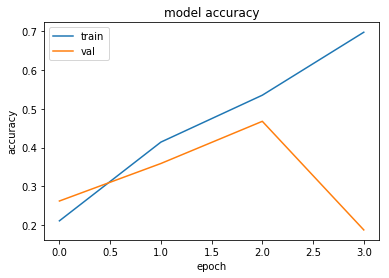

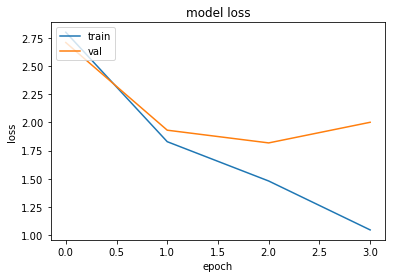

In [6]:
plot_acc_and_loss(history)

#### validating the model performance on the val set

In [7]:
rnd_batches = get_in_batches(val_path, batch_size=batch_size*2, shuffle=True)
val_res = [model.evaluate_generator(rnd_batches, rnd_batches.samples) for i in range(epochs)]
np.round(val_res, 3)
print(val_res)

Found 200 images belonging to 10 classes.


array([[ 1.986,  0.19 ],
       [ 1.988,  0.19 ],
       [ 1.988,  0.19 ],
       [ 1.987,  0.191]])

#### test performance and plot confusion matrix on one batch of 200 images

In [8]:
test_set = get_in_batches(val_path, shuffle=False, class_mode=None, batch_size=200)
pred_classes = model.predict_generator(test_set, 1)
pred_classes = np.argmax(pred_classes, axis=1)
act_classes = test_set.classes

Found 200 images belonging to 10 classes.


[[ 0  0  0  0  0  0  0  0 12  8]
 [ 0  0  0  0  0  0  0  0 17  3]
 [ 0  0  0  0  0  0  0  0 19  1]
 [ 0  0  0  6  0  0  0  0  4 10]
 [ 0  0  0  0  0  0  0  0 11  9]
 [ 0  0  0  0  0  0  0  0 13  7]
 [ 0  0  0  0  0  0  0  0 19  1]
 [ 0  0  0  0  0  0  0  1 19  0]
 [ 0  0  0  0  0  0  0  0 20  0]
 [ 0  0  0  0  0  0  0  0  9 11]]


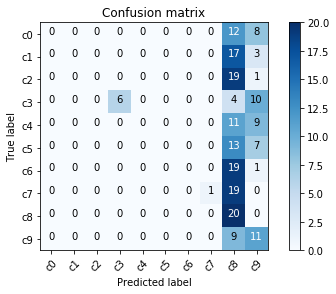

In [9]:
cm = confusion_matrix(act_classes, pred_classes)
plot_confusion_matrix(cm, val_batches.class_indices)
plt.figure()
plt.show()

In [10]:
model.optimizer.lr = 1e-5
history = model.fit_generator(batches,
                    steps_per_epoch=batches.batch_size,
                    validation_data=val_batches,
                    validation_steps=val_batches.batch_size,
                    epochs=epochs)

Epoch 1/4
16/16 [==============================] - 72s - loss: 0.5775 - acc: 0.8828 - val_loss: 2.1062 - val_acc: 0.1895
Epoch 2/4
16/16 [==============================] - 71s - loss: 0.4980 - acc: 0.9023 - val_loss: 2.2560 - val_acc: 0.1855
Epoch 3/4
16/16 [==============================] - 77s - loss: 0.4075 - acc: 0.9102 - val_loss: 2.4921 - val_acc: 0.1375
Epoch 4/4
16/16 [==============================] - 86s - loss: 0.2709 - acc: 0.9413 - val_loss: 2.6672 - val_acc: 0.1613


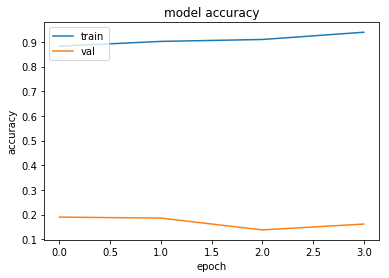

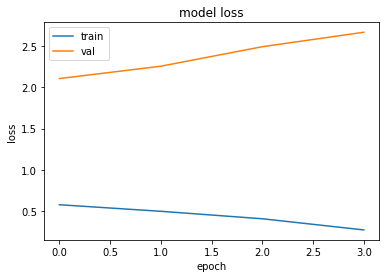

In [11]:
plot_acc_and_loss(history)

In [12]:
rnd_batches = get_in_batches(val_path, batch_size=batch_size*2, shuffle=True)
val_res = [model.evaluate_generator(rnd_batches, rnd_batches.samples) for i in range(epochs)]
np.round(val_res, 3)
print(val_res)

Found 200 images belonging to 10 classes.


array([[ 2.6  ,  0.175],
       [ 2.599,  0.175],
       [ 2.601,  0.175],
       [ 2.603,  0.175]])

In [13]:
test_set = get_in_batches(val_path, shuffle=False, class_mode=None, batch_size=200)
pred_classes = model.predict_generator(test_set, 1)
pred_classes = np.argmax(pred_classes, axis=1)
act_classes = test_set.classes

Found 200 images belonging to 10 classes.


[[ 0  0  0  0  0  0  0  0 14  6]
 [ 0  0  0  0  0  0  0  0 20  0]
 [ 0  0  0  0  0  0  0  0 20  0]
 [ 0  0  0  0  0  0  0  0 19  1]
 [ 0  0  0  0  0  0  0  0 16  4]
 [ 0  0  0  0  0  0  0  0 20  0]
 [ 0  0  0  0  0  0  0  0 20  0]
 [ 0  0  0  0  0  0  0  0 20  0]
 [ 0  0  0  0  0  0  0  0 20  0]
 [ 0  0  0  0  0  0  0  0  5 15]]


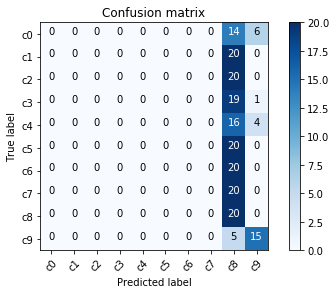

In [14]:
cm = confusion_matrix(act_classes, pred_classes)
plot_confusion_matrix(cm, val_batches.class_indices)
plt.figure()
plt.show()

In [15]:
pred_classes

array([8, 8, 8, 8, 8, 8, 8, 9, 8, 8, 8, 9, 9, 9, 8, 9, 8, 8, 8, 9, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       9, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 8, 8, 8, 8, 8, 8, 9, 8, 8, 8, 8,
       8, 8, 8, 8, 9, 9, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9,
       9, 9, 9, 8, 9, 8, 9, 8, 9, 8, 8, 9, 9, 9, 9, 9])

In [16]:
act_classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9], dtype=int32)